# Prep

In [74]:
!pip install hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 935.5 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp310-cp310-linux_x86_64.whl size=209227 sha256=a557da93621e40fc5f22f4329ce095ced220e7fe3210fefb89580aa49bf4212c
  Stored in directory: /root/.cache/pip/wheels/0e/c3/3c/8a9f55c3de0b09faf919393d4c6f09b11b7421dcaa7243b820
Successfully built hampel


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from scipy.signal import savgol_filter
from hampel import hampel

In [48]:
folder_path = '/content/drive/MyDrive/01.School_related/DoAnChuyenNganh/dataset/segments'

# List all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dfs = []
labels = []
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    if(len(df) < 600): # Skip all df with less than 600 rows
      continue
    match = re.search(r"segment-(\d+)-(\d+)", file_name)
    label = match.group(1) # label them based on the first number in the file name
    df["label"] = int(label)
    dfs.append(df)
print(len(dfs))
print(len(labels))

159
0


In [50]:
merged_df = pd.concat(dfs, axis=0, ignore_index=True)
print(merged_df.shape)

(95400, 53)


# Denoise filters

In [78]:
filtered_data = pd.DataFrame()
for col in merged_df.columns:
      col_series = merged_df[col]
      # Hampel filter
      hampel_filtered = hampel(col_series, window_size=10)
      # Savitzky-Golay filter
      sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
      filtered_data[col] = sg_filtered


In [79]:
print(filtered_data.shape)

(95400, 53)


# Model Training (DNN)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [80]:
X = filtered_data.drop("label", axis=1)
y = filtered_data["label"]

print("Flattened Features (X):")
print(X.shape)
print("Labels (y):")
print(y.shape)

Flattened Features (X):
(95400, 52)
Labels (y):
(95400,)


In [81]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(76320, 52)
(76320,)
(19080, 52)
(19080,)


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [88]:
model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])

In [83]:
# early stopping setting
early_stopping =  EarlyStopping(
                            monitor='val_mae',
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            mode='auto')

In [89]:
# fit
history = model.fit(X_train, y_train,
                      batch_size=100,
                      epochs=200,
                      verbose=1,
                      validation_split=0.2,
                    callbacks=(early_stopping))

Epoch 1/200
611/611 [==============================] - 14s 21ms/step - loss: 2.0998 - mae: 1.1926 - val_loss: 1.5526 - val_mae: 0.9895
Epoch 2/200
611/611 [==============================] - 10s 17ms/step - loss: 1.4062 - mae: 0.9118 - val_loss: 1.2318 - val_mae: 0.8584
Epoch 3/200
611/611 [==============================] - 12s 19ms/step - loss: 1.1929 - mae: 0.8206 - val_loss: 1.5406 - val_mae: 0.9594
Epoch 4/200
611/611 [==============================] - 13s 21ms/step - loss: 1.1276 - mae: 0.7873 - val_loss: 1.0447 - val_mae: 0.7724
Epoch 5/200
611/611 [==============================] - 14s 23ms/step - loss: 1.0428 - mae: 0.7509 - val_loss: 1.1828 - val_mae: 0.7863
Epoch 6/200
611/611 [==============================] - 11s 18ms/step - loss: 0.9572 - mae: 0.7110 - val_loss: 1.1441 - val_mae: 0.7953
Epoch 7/200
611/611 [==============================] - 12s 19ms/step - loss: 0.9198 - mae: 0.6924 - val_loss: 0.8588 - val_mae: 0.6639
Epoch 8/200
611/611 [==============================] - 

# Test model

In [90]:
y_pred = model.predict(X_test)

 # Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

597/597 [==============================] - 3s 5ms/step
Mean Squared Error: 0.33261386
Mean Absolute Error: 0.37751868


In [94]:
print("Predicted values (y_pred) | Actual values (y_test)")
for pred, actual in zip(y_pred[:20], y_test[:20]):
    print("{:.2f}                     | {:.2f}".format(pred[0], actual))

Predicted values (y_pred) | Actual values (y_test)
0.70                     | 1.00
5.11                     | 5.00
0.41                     | 1.00
2.02                     | 2.00
2.01                     | 2.00
3.59                     | 3.00
2.59                     | 2.00
0.42                     | 0.00
4.32                     | 4.00
2.07                     | 2.00
0.64                     | 0.00
0.55                     | 1.00
1.95                     | 2.00
0.98                     | 0.00
2.77                     | 3.00
0.62                     | 1.00
3.77                     | 4.00
0.65                     | 0.00
4.35                     | 4.00
3.87                     | 0.00


In [96]:
def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

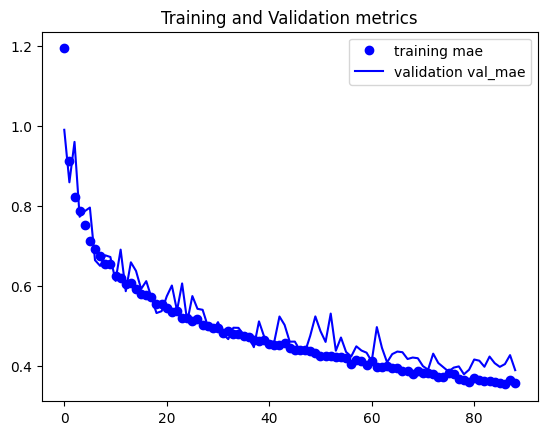

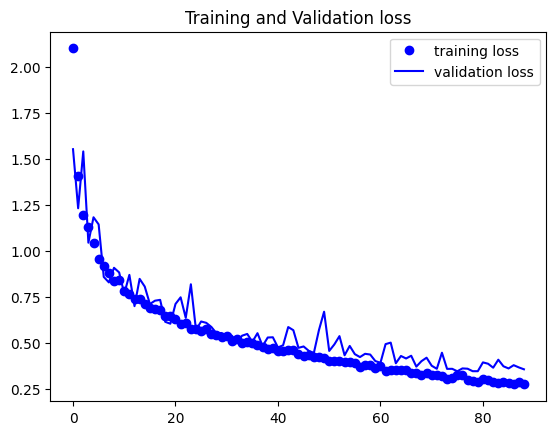

In [97]:
compare_TV(history, "mae", "val_mae")
